### Exploring the Data

In [1]:
import os
import glob

def read_imdb_data(data_dir='Data/imdb-reviews'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """
    # data, labels to be returned in nested dicts matching the dir structure
    data = {}
    labels = {}
    
    for data_type in ['train','test']:
        data[data_type] = {}
        labels[data_type] = {}
        
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign  labels
            for f in files:
                with open(f,encoding="utf8") as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
                    
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), f"{data_type}/{sentiment} data size does not match labels size"
            
    return data, labels    

In [2]:
data, labels = read_imdb_data()
print(f"IMDb reviews: train = {len(data['train']['pos'])} pos / {len(data['train']['neg'])} neg, test = {len(data['test']['pos'])} pos / {len(data['test']['neg'])} neg")

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


In [3]:
print(data['train']['pos'][13])

I enjoyed The Night Listener very much. It's one of the better movies of the summer.<br /><br />Robin Williams gives one of his best performances. In fact, the entire cast was very good. All played just the right notes for their characters - not too much and not too little. Sandra Oh adds a wonderful comic touch. Toni Collette is great as the Mom, and never goes over the top. Everyone is very believable.<br /><br />It's a short movie, just under an hour and a half. I noticed the general release version is nine minutes shorter than the Sundance version. I wonder if some of the more disturbing images were cut from the movie.<br /><br />The director told a story and did it in straightforward fashion, which is a refreshing change from many directors these days who seem to think their job is to impress the audience rather than tell a story and tell it well.<br /><br />Do not be sucker punched by the previews and ads. It is not a Hitchcockian thriller. See The Night Listener because you want

In [4]:
print(data['train']['neg'][13])

This film is about a male escort getting involved in a murder investigation that happened in the circle of powerful men's wives.<br /><br />I thought "The Walker" would be thrilling and engaging, but I was so wrong. The pacing is painfully and excruciatingly slow, that even after 40 minutes of the film nothing happens much. Seriously, the first hour could be condensed into ten minutes. That's how slow it is.<br /><br />The fact that it lacks any thrills or action scenes aggravates the boredom. It's almost shocking that even argument scenes are so plain and devoid of emotion. Maybe it is because of the stiff upper lip of the higher social class? <br /><br />It's sad that "The Walker" becomes such a boring mess, despite such a strong cast. Blame it on the poor plot and even worse pacing.


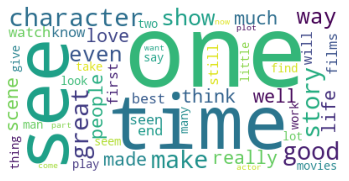

In [5]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

sentiment = 'pos'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize WordCloud Object
wc = WordCloud(background_color='white', max_words=50, stopwords=STOPWORDS.update(['br', 'film', 'movie']))

# Generate and plot WordCloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

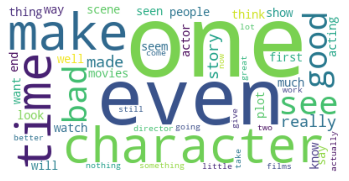

In [6]:
sentiment = 'neg'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize WordCloud Object
wc = WordCloud(background_color='white', max_words=50, stopwords=STOPWORDS.update(['br', 'film', 'movie']))

# Generate and plot WordCloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

### Training and Test Sets

In [7]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    
    # Combine Positive and Negative Reviews and Labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    return data_train, data_test, labels_train, labels_test

data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print(f"IMDb reviews (combined): train = {len(data_train)}, test = {len(data_test)}")

IMDb reviews (combined): train = 25000, test = 25000


### Preprocessing

In [8]:
# Beautifulsoup to remove HTML tags
from bs4 import BeautifulSoup

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anubhav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def review_to_words(review):
    text = BeautifulSoup(review, "html5lib").get_text()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    words = text.split()
    words = [w for w in words if w not in stopwords.words('english')]
    words = [PorterStemmer().stem(w) for w in words]
    
    return words

review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', 'test', 'would', 'make', 'great', 'movi', 'review']

With the function review_to_words() fully implemeneted, we can apply it to all reviews in both training and test datasets. This may take a while, so let's build in a mechanism to write to a cache file and retrieve from it later.

In [10]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Wrote preprocessed data to cache file: preprocessed_data.pkl

--- Raw review ---
This show is awesome! I have been a fan since it premiered, and it only keeps me watching... I've seen some terrible things here, that I wish I hadn't, BUT, it really shows you how addiction affects all involved, not just the addict. You can see all kinds of different addictions, from drugs and alcohol to the shopping addict, or the eating disorder addict. And actually, it's really sad to see some of the famous faces that have come through also. We've seen accomplished musicians, an NBA player, and even young people, who really need the help. And since they have started showing a few follow-ups, that's been awesome too. Now, you can see how they are a long while after their ep aired. If you haven't checked this one out, please do. It's on A&E, and it's awesome! The new eps are Sunday nights at 10PM EST, if I remember correctly... so set your TiVo!

--- Preprocessed words ---
['show', 'awesom', 'fan', 'sinc

### Extracting Bag-of-Words Features

In [14]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # TODO: Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(max_features=vocabulary_size,
                preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
        features_train = vectorizer.fit_transform(words_train).toarray()

        # TODO: Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray()
        
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Wrote features to cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['review', 'alleg', 'spawn', 'glass', 'strive', 'undeni', 'fulli', 'loneli']

--- Preprocessed words ---
['metamoprhi', 'stori', 'dash', 'young', 'scientist', 'rever', 'local', 'colleg', 'brought', 'investig', 'financi', 'provid', 'colleg', 'forc', 'take', 'shortcut', 'typic', 'bad', 'hollywood', 'melodramat', 'fashion', 'first', 'thought', 'movi', 'conclus', 'good', 'bad', 'earli', 'mid', 'eighti', 'cours', 'realiz', 'made', '1990', 'almost', 'propel', '4', 'decid', 'keep', 'mediocr', '5', 'metamorphi', 'occas', 'seem', 'like', 'good', 'movi', 'desper', 'tri', 'get', 'act', 'stellar', 'mostli', 'compet', 'even', 'see', 'occasion', 'glisten', 'modest', 'qualiti', 'pace', 'larg', 'problem', 'movi', 'think', 'watch', 'nineti', 'minut', 'realiz', 'watch', 'hour', 'special', 'effect', 'stellar', 'director', 'seem', 'mostli', 'compet', 'enough', 'work', 'around', 'weak', 'lead', 'mildli', 'charismat', 'male'

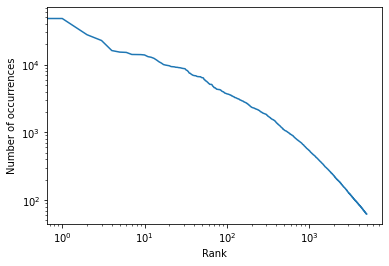

In [15]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

In [16]:
import sklearn.preprocessing as pr

# TODO: Normalize BoW features in training and test set
features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

In [17]:
from sklearn.naive_bayes import GaussianNB

# TODO: Train a Guassian Naive Bayes classifier
clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.8198, test = 0.72768


In [18]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)

    # TODO: Classify the data using GradientBoostingClassifier
    clf.fit(X_train, y_train)

    # TODO(optional): Perform hyperparameter tuning / model selection
    
    # TODO: Print final training & test accuracy
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))
    
    # Return best classifier model
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GradientBoostingClassifier] Accuracy: train = 0.79472, test = 0.79004


In [19]:
# Write a sample review and set its true sentiment
my_review = "I thought it would be just like all the other boring sequels that are coming out everyday. But had I not gone, I would've missed out on a treat. Not only was it not boring, it kept me at the edge of my seat till the end."
true_sentiment = 'pos'  # sentiment must be 'pos' or 'neg'

# TODO: Apply the same preprocessing and vectorizing steps as you did for your training data
my_words = review_to_words(my_review)
vectorizer = CountVectorizer(vocabulary=vocabulary,
                             preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
my_bow_features = vectorizer.transform([my_words]).toarray()  # pass an array of 1 element

# TODO: Then call your classifier to label it
predicted_sentiment = clf2.predict(my_bow_features)[0]
print("--- My review ---")
print(my_review)
print("\n--- Preprocessed words ---")
print(my_words)
print("\nTrue sentiment: {}, predicted sentiment: {}".format(true_sentiment, predicted_sentiment))

--- My review ---
I thought it would be just like all the other boring sequels that are coming out everyday. But had I not gone, I would've missed out on a treat. Not only was it not boring, it kept me at the edge of my seat till the end.

--- Preprocessed words ---
['thought', 'would', 'like', 'bore', 'sequel', 'come', 'everyday', 'gone', 'would', 'miss', 'treat', 'bore', 'kept', 'edg', 'seat', 'till', 'end']

True sentiment: pos, predicted sentiment: neg


In [26]:
from keras.datasets import imdb  # import the built-in imdb dataset in Keras

# Set the vocabulary size
vocabulary_size = 5000

# Load in training and test data (note the difference in convention compared to scikit-learn)
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocabulary_size)
print("Loaded dataset with {} training samples, {} test samples".format(len(X_train), len(X_test)))

Loaded dataset with 25000 training samples, 25000 test samples


In [27]:
# Inspect a sample review and its label
print("--- Review ---")
print(X_train[7])
print("--- Label ---")
print(y_train[7])

--- Review ---
[1, 4, 2, 716, 4, 65, 7, 4, 689, 4367, 2, 2343, 4804, 2, 2, 2, 2, 2315, 2, 2, 2, 2, 4, 2, 628, 2, 37, 9, 150, 4, 2, 4069, 11, 2909, 4, 2, 847, 313, 6, 176, 2, 9, 2, 138, 9, 4434, 19, 4, 96, 183, 26, 4, 192, 15, 27, 2, 799, 2, 2, 588, 84, 11, 4, 3231, 152, 339, 2, 42, 4869, 2, 2, 345, 4804, 2, 142, 43, 218, 208, 54, 29, 853, 659, 46, 4, 882, 183, 80, 115, 30, 4, 172, 174, 10, 10, 1001, 398, 1001, 1055, 526, 34, 3717, 2, 2, 2, 17, 4, 2, 1094, 871, 64, 85, 22, 2030, 1109, 38, 230, 9, 4, 4324, 2, 251, 2, 1034, 195, 301, 14, 16, 31, 7, 4, 2, 8, 783, 2, 33, 4, 2945, 103, 465, 2, 42, 845, 45, 446, 11, 1895, 19, 184, 76, 32, 4, 2, 207, 110, 13, 197, 4, 2, 16, 601, 964, 2152, 595, 13, 258, 4, 1730, 66, 338, 55, 2, 4, 550, 728, 65, 1196, 8, 1839, 61, 1546, 42, 2, 61, 602, 120, 45, 2, 6, 320, 786, 99, 196, 2, 786, 2, 4, 225, 4, 373, 1009, 33, 4, 130, 63, 69, 72, 1104, 46, 1292, 225, 14, 66, 194, 2, 1703, 56, 8, 803, 1004, 6, 2, 155, 11, 4, 2, 3231, 45, 853, 2029, 8, 30, 6, 117, 430

In [29]:
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print("--- Review (with words) ---")
print([id2word.get(i, " ") for i in X_train[7]])
print("--- Label ---")
print(y_train[7])

--- Review (with words) ---
['the', 'of', 'and', 'local', 'of', 'their', 'br', 'of', 'attention', 'widow', 'and', 'captures', 'parties', 'and', 'and', 'and', 'and', 'excitement', 'and', 'and', 'and', 'and', 'of', 'and', 'english', 'and', 'like', 'it', 'years', 'of', 'and', 'unintentional', 'this', 'hitchcock', 'of', 'and', 'learn', 'everyone', 'is', 'quite', 'and', 'it', 'and', 'such', 'it', 'bonus', 'film', 'of', 'too', 'seems', 'he', 'of', 'enough', 'for', 'be', 'and', 'editing', 'and', 'and', 'please', 'great', 'this', 'of', 'shoots', 'thing', '3', 'and', "it's", 'mentioning', 'and', 'and', 'given', 'parties', 'and', 'back', 'out', 'interesting', 'times', 'no', 'all', 'average', 'talking', 'some', 'of', 'nor', 'seems', 'into', 'best', 'at', 'of', 'every', 'cast', 'i', 'i', 'inside', 'keep', 'inside', 'large', 'viewer', 'who', 'obscure', 'and', 'and', 'and', 'movie', 'of', 'and', 'entirely', "you've", 'see', 'because', 'you', 'deals', 'successful', 'her', 'anything', 'it', 'of', 'ded

In [30]:
from keras.preprocessing import sequence

# Set the maximum number of words per document (for both training and testing)
max_words = 500

# Pad sequences in X_train and X_test
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [31]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# TODO: Design your model
embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# Specify training parameters: batch size and number of epochs
batch_size = 64
num_epochs = 3

# Reserve/specify some training data for validation (not to be used for training)
X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]  # rest for training

# Train your model
model.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

Epoch 1/3
390/390 [==============================] - 189s 483ms/step - loss: 0.4995 - accuracy: 0.7581 - val_loss: 0.2713 - val_accuracy: 0.8906
Epoch 2/3
390/390 [==============================] - 194s 498ms/step - loss: 0.3069 - accuracy: 0.8742 - val_loss: 0.2297 - val_accuracy: 0.9219
Epoch 3/3
390/390 [==============================] - 195s 499ms/step - loss: 0.2476 - accuracy: 0.9037 - val_loss: 0.2564 - val_accuracy: 0.8750


In [35]:
# Save your model, so that you can quickly load it in future (and perhaps resume training)
model_file = "rnn_model.h5"  # HDF5 file
model.save(os.path.join(cache_dir, model_file))

In [36]:
# Evaluate your model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.8739200234413147
